Configuración

In [3]:
!pip install opencv-python-headless gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00


In [4]:
from google.colab import drive

# Ruta
drive.mount('/content/drive')

# Librerias
import os
import random
import datetime
import shutil
import re
import glob
import cv2
import gradio as grad
import tempfile
import mimetypes
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sbn

from PIL import Image
from collections import Counter


# Extras
import tensorflow as tf

from tensorflow.keras import layers, models, Input, regularizers, initializers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img, load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Extensión de TensorBoard
%load_ext tensorboard

Carga del dataset

In [6]:
# Rutas originales pero con las carpetas que mencionaste para validar
ruta_train_drive = "/content/drive/MyDrive/simpsons_dataset"
ruta_test_drive = "/content/drive/MyDrive/kaggle_simpson_testset"

# Ruta local (igual que antes)
ruta_train_pc = "/content/simpsons_dataset"
ruta_test_pc = "/content/test_simpsons"

# Validar si las rutas de Drive existen
print("Train OK:", os.path.exists(ruta_train_drive))
print("Test OK:", os.path.exists(ruta_test_drive))


Train OK: True
Test OK: True


Carpetas y personajes

In [8]:
# Tamaño de las imágenes que usaremos
IMG_SIZE = 64

# Diccionario de personajes (18 más frecuentes)
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Función para cargar imágenes de entrenamiento
def load_train_set(dirname, map_characters, verbose=True):
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        folder_path = os.path.join(dirname, character)
        if not os.path.exists(folder_path):
            continue
        images = [f for f in os.listdir(folder_path) if f.endswith(("jpg", "jpeg", "png"))]
        if verbose:
            print(f"Leyendo {len(images)} imágenes de {character}")
        for image_name in images:
            image = cv2.imread(os.path.join(folder_path, image_name))
            if image is not None:
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                X_train.append(image)
                y_train.append(label)
    return np.array(X_train), np.array(y_train)

# Función para cargar imágenes de test
def load_test_set(dirname, map_characters, verbose=True):
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            if image is not None:
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                X_test.append(image)
                y_test.append(reverse_dict[char_name])
    if verbose:
        print(f"Leídas {len(X_test)} imágenes de test")
    return np.array(X_test), np.array(y_test)

In [10]:
X, y = load_train_set(ruta_train_drive, MAP_CHARACTERS)
X_t, y_t = load_test_set(ruta_test_drive, MAP_CHARACTERS)

print(f"Total imágenes de entrenamiento: {X.shape}")
print(f"Total imágenes de test: {X_t.shape}")

Leyendo 913 imágenes de abraham_grampa_simpson
Leyendo 623 imágenes de apu_nahasapeemapetilon
Leyendo 1342 imágenes de bart_simpson
Leyendo 1193 imágenes de charles_montgomery_burns
Leyendo 986 imágenes de chief_wiggum
Leyendo 469 imágenes de comic_book_guy
Leyendo 457 imágenes de edna_krabappel
Leyendo 2246 imágenes de homer_simpson
Leyendo 498 imágenes de kent_brockman
Leyendo 1206 imágenes de krusty_the_clown
Leyendo 1354 imágenes de lisa_simpson
Leyendo 1291 imágenes de marge_simpson
Leyendo 1079 imágenes de milhouse_van_houten
Leyendo 1452 imágenes de moe_szyslak
Leyendo 1454 imágenes de ned_flanders
Leyendo 358 imágenes de nelson_muntz
Leyendo 1194 imágenes de principal_skinner
Leyendo 877 imágenes de sideshow_bob
Leídas 890 imágenes de test
Total imágenes de entrenamiento: (18992, 64, 64, 3)
Total imágenes de test: (890, 64, 64, 3)


In [11]:
X = X.astype('float32') / 255.0
X_t = X_t.astype('float32') / 255.0

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=64
)

print(f"Imágenes para entrenar: {X_train.shape}, Para Validar: {X_val.shape}")

Imágenes para entrenar: (15193, 64, 64, 3), Para Validar: (3799, 64, 64, 3)


In [12]:
numero_clases = len(MAP_CHARACTERS)

model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolución 1
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolución 2
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolución 3
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Capa completamente conectada
    layers.Flatten(),
    layers.Dense(504, activation='relu'),
    layers.Dropout(0.7),

    # Capa de salida
    layers.Dense(numero_clases, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 504)            │     2,064,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 504)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         9,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,464,314 (9.40 MB)

 Trainable params: 2,463,354 (9.40 MB)

 Non-trainable params: 960 (3.75 KB)

entrenamiento modelo

In [13]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=2
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=3
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1
)

In [14]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=124,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1925 - loss: 3.2826
Epoch 1: val_loss improved from inf to 10.20714, saving model to best_model.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.1931 - loss: 3.2770 - val_accuracy: 0.1574 - val_loss: 10.2071 - learning_rate: 0.0010
Epoch 2/80
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4321 - loss: 1.8662
Epoch 2: val_loss improved from 10.20714 to 3.92562, saving model to best_model.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4330 - loss: 1.8636 - val_accuracy: 0.2022 - val_loss: 3.9256 - learning_rate: 0.0010
Epoch 3/80
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5850 - loss: 1.3641
Epoch 3: val_loss improved from 3.92562 to 3.81238, saving model to best_model.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5852 - loss: 1.3632 - val_accuracy: 0.2938 - val_loss: 3.8124 - learning_rate: 0.0010
Epoch 4/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6588 - loss: 1.0930
Epoch 4: val_loss improved from 3.81238 to 1.21388, saving model to best_model.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6589 - loss: 1.0926 - val_accuracy: 0.6307 - val_loss: 1.2139 - learning_rate: 0.0010
Epoch 5/80
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7370 - loss: 0.8282
Epoch 5: val_loss improved from 1.21388 to 0.85535, saving model to best_model.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7371 - loss: 0.8277 - val_accuracy: 0.7331 - val_loss: 0.8553 - learning_rate: 0.0010
Epoch 6/80
122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7817 - loss: 0.6843
Epoch 6: val_loss improved from 0.85535 to 0.65283, saving model to best_model.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7818 - loss: 0.6841 - val_accuracy: 0.8013 - val_loss: 0.6528 - learning_rate: 0.0010
Epoch 7/80
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8302 - loss: 0.5497
Epoch 7: val_loss improved from 0.65283 to 0.60095, saving model to best_model.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8303 - loss: 0.5494 - val_accuracy: 0.8278 - val_loss: 0.6010 - learning_rate: 0.0010
Epoch 8/80
122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8699 - loss: 0.4186
Epoch 8: val_loss did not improve from 0.60095
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8698 - loss: 0.4189 - val_accuracy: 0.8334 - val_loss: 0.6116 - learning_rate: 0.0010
Epoch 9/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8861 - loss: 0.3551
Epoch 9: val_loss did not improve from 0.60095

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8861 - loss: 0.3552 - val_accuracy: 0.7847 - val_loss: 0.8020 - learning_rate: 0.0010
Epoch 10/80
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9196 - loss: 0.2463
Epoch 10: val_loss improved from 0.60095 to 0.33883, saving model to best_model.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9197 - loss: 0.2458 - val_accuracy: 0.9168 - val_loss: 0.3388 - learning_rate: 3.0000e-04
Epoch 11/80
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9489 - loss: 0.1579
Epoch 11: val_loss did not improve from 0.33883
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9489 - loss: 0.1580 - val_accuracy: 0.9150 - val_loss: 0.3783 - learning_rate: 3.0000e-04
Epoch 12/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9607 - loss: 0.1274
Epoch 12: val_loss did not improve from 0.33883

Epoch 12: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9607 - loss: 0.1274 - val_accuracy: 0.9229 - val_loss: 0.3432 - learning_rate: 3.0000e-04
Epoch 13/80
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9692 - loss: 0.1026
Epoch 13: val_loss improved from 0.33883 to 0.33305, saving model to best_model.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9692 - loss: 0.1025 - val_accuracy: 0.9266 - val_loss: 0.3331 - learning_rate: 9.0000e-05
Epoch 14/80
122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9671 - loss: 0.0972
Epoch 14: val_loss did not improve from 0.33305
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9671 - loss: 0.0971 - val_accuracy: 0.9284 - val_loss: 0.3341 - learning_rate: 9.0000e-05
Epoch 15/80
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9710 - loss: 0.0869
Epoch 15: val_loss did not improve from 0.33305

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9710 - loss: 0.0868 - val_accuracy: 0.9273 - val_loss: 0.3363 - learning_rate: 9.0000e-05
Epoch 16/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9760 - loss: 0.0766
Epoch 16: val_loss did not improve from 0.33305
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9760 - loss: 0.0766 

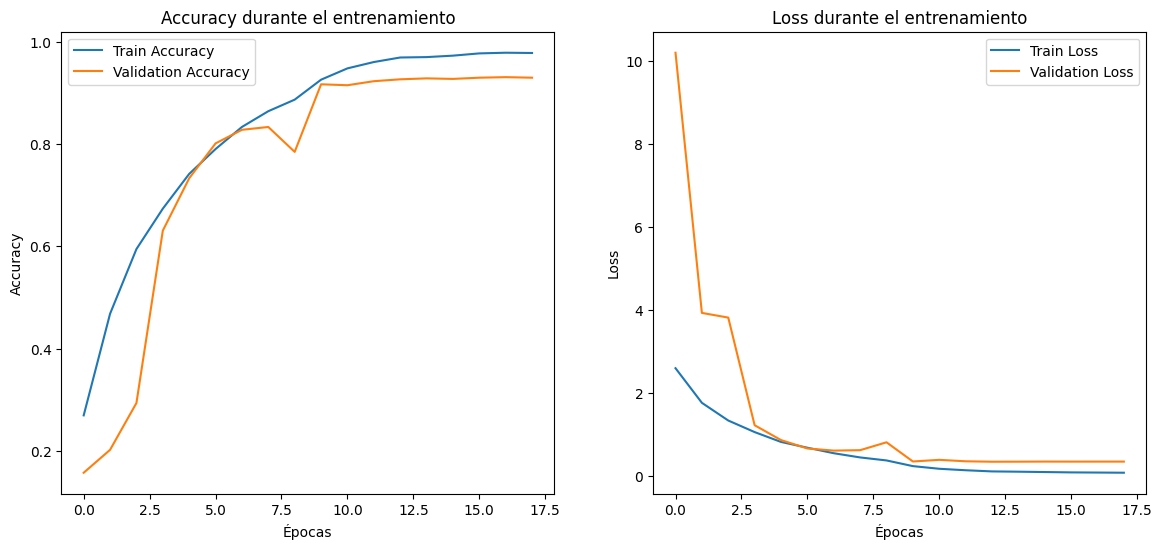

In [15]:
# Grafico de metricas

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
model = load_model('best_model.h5')

In [17]:
y_pred_probs = model.predict(X_t)
y_pred = np.argmax(y_pred_probs, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


In [18]:
# Reporte por clase
print("Classification Report:")
print(classification_report(y_t, y_pred, target_names=list(MAP_CHARACTERS.values())))

Classification Report:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.92      0.96        48
  apu_nahasapeemapetilon       1.00      1.00      1.00        50
            bart_simpson       0.98      0.98      0.98        50
charles_montgomery_burns       0.90      0.98      0.94        48
            chief_wiggum       1.00      1.00      1.00        50
          comic_book_guy       1.00      0.96      0.98        49
          edna_krabappel       0.98      1.00      0.99        50
           homer_simpson       0.91      1.00      0.95        50
           kent_brockman       0.98      1.00      0.99        50
        krusty_the_clown       0.98      1.00      0.99        50
            lisa_simpson       1.00      0.94      0.97        50
           marge_simpson       1.00      0.98      0.99        50
     milhouse_van_houten       1.00      1.00      1.00        49
             moe_szyslak       1.00      0.94      0

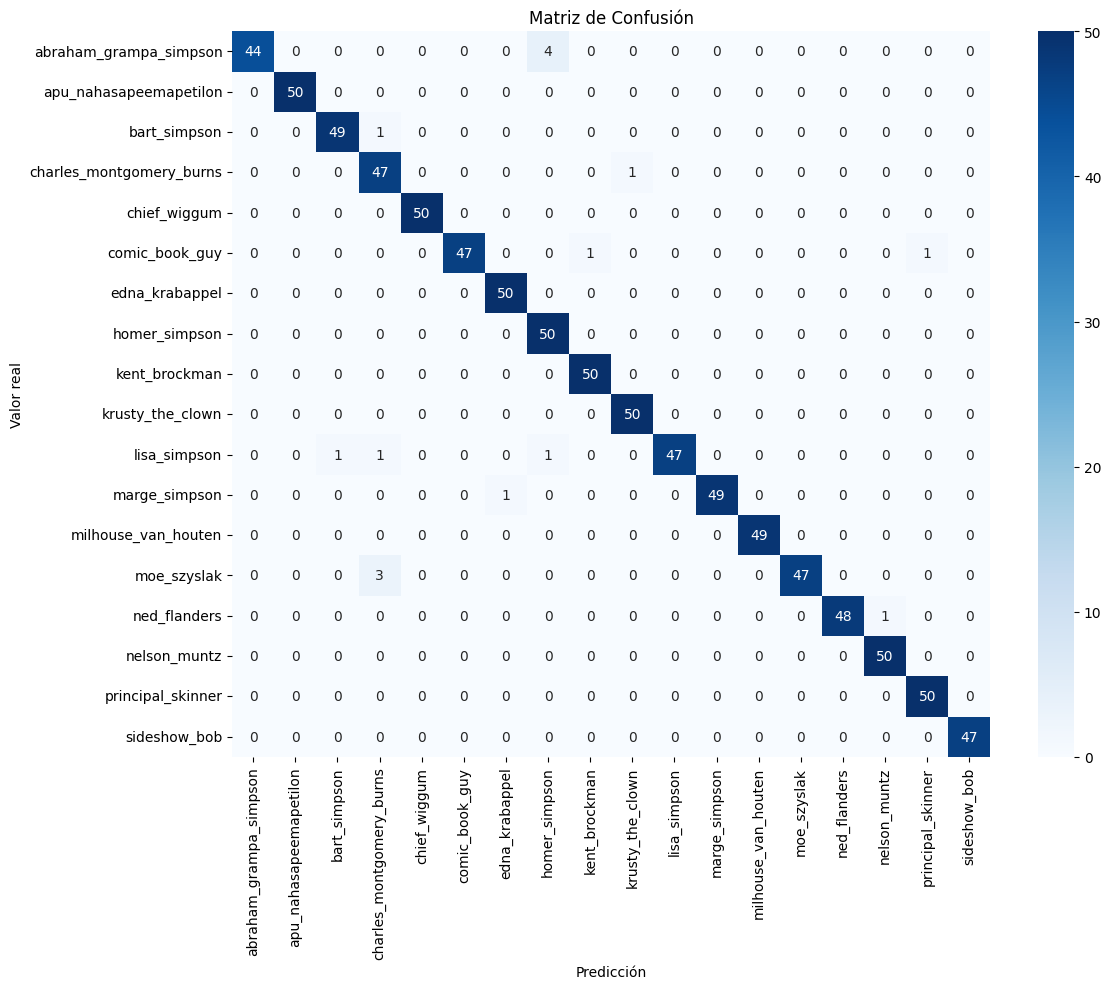

In [19]:
cm = confusion_matrix(y_t, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=MAP_CHARACTERS.values(), yticklabels=MAP_CHARACTERS.values(), cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
# Cargar modelo
model = load_model('best_model.h5')

# Tamaño esperado por la red
IMG_SIZE = 64

# Lista de nombres de clase
class_names = list(MAP_CHARACTERS.values())

# Función de predicción frame a frame
def predict_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_preds = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocesar el frame
        frame_resized = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame_norm = frame_resized.astype('float32') / 255.0
        frame_input = np.expand_dims(frame_norm, axis=0)

        # Predicción
        prediction = model.predict(frame_input, verbose=0)
        pred_class = np.argmax(prediction)
        frame_preds.append(class_names[pred_class])

    cap.release()

    # Analizar predicciones
    if not frame_preds:
        return "No se pudo procesar el video."

    top = Counter(frame_preds).items()
    result = "\n".join([f"{char}: {count} frames" for char, count in top])
    return f"Personajes detectados:\n{result}"

# Interfaz Gradio
iface = grad.Interface(
    fn=predict_video,
    inputs=grad.Video(label="Sube un video de Los Simpsons"),
    outputs=grad.Textbox(label="Resultado"),
    title="Detector de personajes de Los Simpsons",
    description="Este modelo analiza frame por frame un video y detecta los personajes de los simpsons."
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://baed8c9cb24d8f31eb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
